# Assignment 1: Keeping Up With Social Information (Part 1)
## © Cristian Danescu-Niculescu-Mizil 2019
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday January 30th

This assignment is **individual**.

In this assignment we are practicing with post-processing on a conversational dataset taken from the reality TV show "Keeping Up With The Kardashians" and gathering some basic statistics about it. 

In the next assignment (Assignment 2) we will extend these tools to analyze conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* word tokenization
* histogram plotting using `matplotlib`
* character analysis via conversational language
* familiarize yourself with basic numpy usage

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented within a given amount of time to ensure that your logic is correct.

Your solution to A1 should finish running in **less than 5 minutes**.
For your information, it takes less than 1 minute to run our solution for the entire A1.
Also make sure to remove any **redundant print statements** to speed things up and prevent generating unnecessary outputs.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

You are expected to submit this .ipynb as your submission for Assignment 1. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

In [3]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

## Preliminary Data Cleansing
**Note: The following content is for you to review to understand how we cleaned and prepared the data for the analysis below.**

We will be continuing where we left off from Assignment 0. 

### Removing duplicates
If you are to examine the original transcripts you will see that many of them are near-duplicates, but most are not *perfect* duplicates. This is problematic, because we cannot simply remove identical transcripts.  Furthermore, we cannot just throw away documents that have large overlap, because we would be throwing away the valuable data that is *not* overlapping.

We therefore have to treat the transcripts as sequences, rather than as entire documents, and just remove subsequences that overlap.

We therefore used a standard python `difflib` package to write the `find_overlaps` function:

```python
import difflib
def find_overlaps(transcript_a, transcript_b, threshold=5):
    """Find and return the indices of overlapping subsequences between the two transcripts.
    Only return overlapping sequences that consist of at least `threshold` entries."""
    
    # We consider that two transcripts overlap when the messages
    # and the speakers are the same, but not the timestamp.
    
    # Massage the transcripts to disregard timestamp information.
    # note that a tuple is hashable, so is okay to use for difflib's SequenceMatcher class.
    msgs_a = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_a]
    msgs_b = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_b]
    matcher = difflib.SequenceMatcher(None, msgs_a, msgs_b)
    return list(filter(lambda tup: tup[2] >= threshold, matcher.get_matching_blocks()))
```

We now use the function above to remove duplicate subsequences. At each step, assume we have a list of "good" transcripts that have already been processed. When considering a new transcript, we first remove all subsequences that overlap with any of the already processed ones. Then, we split up the chunks that are not removed, and consider each of them a new transcript.

```python
deduped_transcripts = []
all_keys = sorted(transcripts.keys())

for key in all_keys:
    transcript = transcripts[key]
    for _, good_transcript in deduped_transcripts:
        overlaps = find_overlaps(transcript, good_transcript)
        for idx_a, _, size in overlaps:
            transcript[idx_a:idx_a + size] = [None] * size
    
    for is_not_none, group in groupby(transcript, lambda x: x is not None):
        if is_not_none:
            subtranscript = list(group)
            deduped_transcripts.append((key, subtranscript))
```

The `deduped_transcripts` are what you are now analyzing for the rest of the assignment. 

In [5]:
## We are loading the pickle file that contains all the deduped transcripts from Assignment 0
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are also loading a pickle file of the titles file that we determined in the beginning of Assignment 0
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)

# Language analysis

## Identifying the words
It's time to get down to the bread-and-butter of language analysis: the words used.  For simplification, **we consider a word to be a sequence of alphabetical characters. Treat all other characters as delimiters and do not return them.**


## Question 1 (Code Completion): Tokenization 

In the cell below: *Write a function to 'tokenize' a string into the constituent words*. 

You **must** use regex to satisfy the function specification. We recommend you leverage `re.findall`. 

Hint: Check out this online regex calculator: [here](https://regex101.com/)

In [6]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # YOUR CODE HERE
    text= text.lower()
    return re.findall(r'[a-z]+', text)

In [7]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert tokenize("It's time to get down to the bread-and-butter") == \
    ['it', 's', 'time', 'to', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']
assert tokenize("Life, Liberty, & the Pursuit of Happiness") == \
    ['life', 'liberty', 'the', 'pursuit', 'of', 'happiness']

## Question 2 (Code Completion): Tokenization of Entire Transcript

In the cell below complete the function: *Leveraging the tokenize method to tokenize an entire transcript*. 

In [8]:
def tokenize_transcript(tokenize_method,input_transcript):
    """Returns a list of words contained in an entire transcript.
    Params: {tokenize_method: Function (a -> b),
             input_transcript: Tuple}
    Returns: List
    """
    # YOUR CODE HERE
    tokenized =[]
    for i in input_transcript[1]:
        tokenized= tokenized+tokenize_method(i["text"])
    return tokenized

In [9]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert len(tokenize_transcript(tokenize,deduped_transcripts[0])) > 6000 and \
    len(tokenize_transcript(tokenize,deduped_transcripts[0])) < 7000

## Question 3 (Code Completion) Number of Tokens
In the cell below write a function to *count how many tokens are used in the deduplicated transcripts in total*

In [10]:
def num_dedup_tokens(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    count=0
    for i in input_transcripts:
        count+=len(tokenize_transcript_method(tokenize_method,i))
    return count

In [11]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) > 200000 and \
    num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) < 300000

## Question 4 (Code Completion) Number of Distinct Words

In the cell below write a function to *count how many distinct words are in the deduplicated transcripts in total*. 

Hint: Use a *set*

In [12]:
def num_distinct_words(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of distinct tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    token_dict={}
    for i in input_transcripts:
        for j in tokenize_transcript_method(tokenize_method,i):
            if j not in token_dict:
                token_dict[j]=1
    return len(token_dict)

In [13]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) > 8000 and \
    num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) < 9000

# Question 5 (Code Completion) Word Episode Counts

This question is asking you to build a dictionary `word_episode_count[word]` = *number of episodes in which the word appears in*. 

*Note: Keep in mind that the de-duplicated transcripts don't have unique titles!
Recall from A0 that **one episode corresponds to exactly one title** (but not necessarily to only one transcript).*

**Your code should ideally take less than 1 second (or a few seconds) to run. If it does not, then you should be able to find a better answer.**

In the cell below write a function that: *for each distinct (unique) word, in how many different episodes does it appear?* 

In [14]:
def build_word_episode_count(tokenize_method,tokenize_transcript_method,input_transcripts,input_titles):
    """Returns a dictionary with the number of episodes each distinct word appears
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_titles: Dictionary}
        Returns: Dict
    """
    # YOUR CODE HERE
    episode_dict={}
    for val in input_titles.values():
        if val not in episode_dict:
            episode_dict[val]={}
    for i,j in input_transcripts:
        token_dict={}
        for text_word in tokenize_transcript_method(tokenize_method,(i,j)):
            if text_word not in episode_dict[titles[i]]:
                episode_dict[titles[i]][text_word]=1
    word_episode_count={}  
    for episode in episode_dict:
        for key in episode_dict[episode]:
            if key not in word_episode_count:
                word_episode_count[key]=1
            else:
                word_episode_count[key]=word_episode_count[key]+1 
    return word_episode_count

In [15]:
word_episode_count = build_word_episode_count(tokenize,tokenize_transcript,deduped_transcripts,titles)   

In [16]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_word_episode_count returns the correct output"""
assert word_episode_count['quarter'] == 2
assert word_episode_count['made'] == 40
assert word_episode_count['never'] == 49

## Question 6 (Free Response): Distribution Analysis

For this question you will be plotting a histogram of the distribution of the number of episodes in which words appear. 

The *x axis* should correspond to the *number of episodes* in which a word is mentioned, and the *y axis* should show *how many words* are in each bin. 

Note: Use the default matplotlib settings. You may find this tutorial helpful: https://matplotlib.org/3.0.2/tutorials/introductory/pyplot.html

Create a new cell with the histogram below. And give an analysis of the histogram: What do you observe?

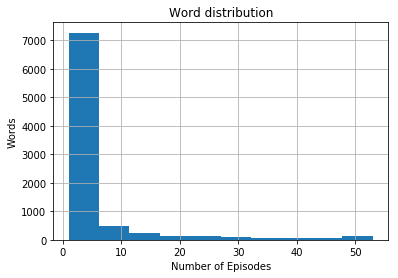

In [17]:
# YOUR CODE HERE 

plt.hist(word_episode_count.values())
plt.xlabel('Number of Episodes')
plt.ylabel('Words')
plt.title('Word distribution')
plt.grid(True)
plt.show()

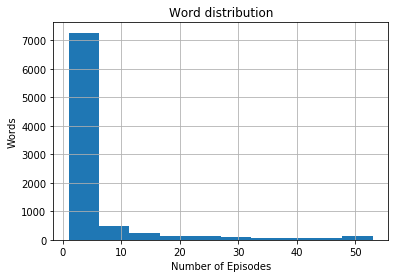

The majority of words only occur in one episode. There are slightly more words that occurs in every episodes, as opposed to the number of words that occur in some of the episodes, but this still is far inferior to the number of words that occur in only one episode.  

## Question 7 (Code Completition): Good Types

For the following question you will build an alphabetically sorted list of all words that appear in **more than one episode.** We shall refer to these words as *good types*. The strategy here is to eliminate very specific words that occur too rarely. The word *type* here refers to word types. Word types are unique words, i.e. *hello* and *goodbye* are two distinct word types. ["You say goodbye, and I say hello, hello, hello"](https://www.youtube.com/watch?v=rblYSKz_VnI&feature=youtu.be&t=16s) (warning -- link will play sound) is a sequence of 9 tokens (ignoring punctuation) and contains one *goodbye* type token, and three *hello* type tokens.

In the cell below fufill the specifications above and have the function: *produce an alphabetically sorted list of good types*. 

In [18]:
def output_good_types(input_word_counts):
    """Returns a list of good types in alphabeitcally sorted order
        Params: {input_word_counts: Dict}
        Returns: List
    """
    # YOUR CODE HERE
    lst=[]
    for word in input_word_counts:
        if(input_word_counts[word]>1):
            lst.append(word)
    lst.sort()
    return lst

In [19]:
good_types = output_good_types(word_episode_count)
n_good_types = len(good_types)

In [20]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that output_good_types returns the correct output"""
assert n_good_types > 4500 and n_good_types < 5000
assert good_types[0:5] == ['a','aah','ability','able','about']

## Question 7b (Free Response): Good Types

In the cell below answer the following: *How many good_types there are? What are the first 10 in alphabetical order?*

There are 4517 good_types.
The first 10 in alphabetical order are: ['a', 'aah', 'ability', 'able', 'about', 'absolute', 'absolutely', 'absurd', 'accent', 'accept'].

From now on, the use of array data structures from `numpy` is highly recommended and required in some places. If you've never used numpy before, it will take some time to get used to. In general, numpy is a library that you can use to handle vector/matrix/tensor operations, including creation, modification, and compositions (add, sub, mul, etc.). For example, try running the following code:

In [21]:
A = np.array([[1,2,3], [4,6,2]]) 
B = np.array([[1,2],[5,3],[1,1]])
print(A) #A is a 2x3 matrix
print(B) #B is a 3x2 matrix
print(A.dot(B)) #A.dot(B) is a 2 by 2 matrix
print(np.sum(A, axis=0)) #np.sum(A, axis=0) sums along columns
print(np.sum(B, axis=1)) #np.sum(B, axis=1) sums along rows

[[1 2 3]
 [4 6 2]]
[[1 2]
 [5 3]
 [1 1]]
[[14 11]
 [36 28]]
[5 8 5]
[3 8 2]


You're welcome to find your own resources to learn more about numpy (there are lots of them) but one good introduction is [Justin Johnson's writeup](http://cs231n.github.io/python-numpy-tutorial/#numpy).

We will be using vectors and arrays with *n_good_types* columns, such that each good type corresponds to a column, in alphabetical order.

## Question 8 (Code Completion): Word Frequencies

What can you say about the most frequently used words? Would you expect to find the same ordering of frequent words in, say, the NY Times?

Note that we are talking about how many times a word appears over all episodes, rather than how many episodes a word appears in.

In the cell below, complete the function to *find the most frequently occurring words ("good types")*.

In [22]:
def create_ranked_good_types(tokenize_method,tokenize_transcript_method,input_transcripts,input_good_types):
    """Returns a list of good types in reverse sorted order in the form:
        [(word_1,word_count_1),
        ...
        (word_10,word_count_10)]
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_good_types: List}
        Returns: List
    """
    # YOUR CODE HERE
    good_dict={}
    for val in input_good_types:
            good_dict[val]=0

    for i in input_transcripts:
        for text_word in tokenize_transcript_method(tokenize_method,i):
            if text_word in good_dict:
                good_dict[text_word]=good_dict[text_word]+1
                
    output_good_types=[]  
    for index in range(0,len(input_good_types)):
            output_good_types.append((good_dict[input_good_types[index]],input_good_types[index]))
    output_good_types.sort(reverse=True)
    output_good_types2=[] 
    for x,y in output_good_types:
        output_good_types2.append((y,x))
    return output_good_types2

In [23]:
ranked_counts = create_ranked_good_types(tokenize,tokenize_transcript,deduped_transcripts,good_types)

In [24]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_ranked_good_types returns the correct output"""
assert ranked_counts[0:2] == [('i',13972),('you',10920)]

## Characterizing characters' language

Moving on, we will only be considering a subset of characters, arguably the most important ones.

In [25]:
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']

n_speakers = len(good_speakers)

## Question 9 (Code Completion): Character Word Occurrences

In the cell below you will be asked to determine the *occurrences words by each character*

This function will require you to return a numpy array of shape `n_speakers` by `n_good_types` such that the entry `(i,j)` indicates how many times speaker i says word j.

In [28]:
def create_word_occurrence_matrix(
    tokenize_method,
    input_transcripts,
    input_speakers,
    input_good_types):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j.
    
    Params: {tokenize_method: Function (a -> b),
             input_transcripts: Tuple,
             input_speakers: List,
             input_good_types: List}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    output_arr = np.zeros((len(input_speakers),len(input_good_types)))
    for i,j in input_transcripts:
        for transcript in j:           
            tokens=tokenize_method(transcript["text"])
            speaker=transcript["speaker"]
            for word in tokens:
                try:
                    output_arr[input_speakers.index(speaker)][input_good_types.index(word)]= \
                        output_arr[input_speakers.index(speaker)][input_good_types.index(word)]+1                   
                except:
                    pass
    return output_arr

In [29]:
word_matrix = create_word_occurrence_matrix(tokenize,deduped_transcripts,good_speakers,good_types)

[('kardashians/153890', [{'speaker': 'KHLOE', 'timestamp': '00:00:23', 'text': "You don't have your own credit card?"}, {'speaker': 'BRUCE', 'timestamp': '00:00:25', 'text': "I don't even have a credit card."}, {'speaker': 'BRUCE', 'timestamp': '00:00:26', 'text': 'I know.'}, {'speaker': 'KHLOE', 'timestamp': '00:00:27', 'text': 'You are such a little girl.'}, {'speaker': 'BRUCE', 'timestamp': '00:00:31', 'text': 'I know.'}, {'speaker': 'BRUCE', 'timestamp': '00:00:32', 'text': "I'm a wuss, yeah."}, {'speaker': 'BRUCE', 'timestamp': '00:00:33', 'text': 'When it comes to that stuff.'}, {'speaker': 'KHLOE', 'timestamp': '00:00:34', 'text': "You're a puss."}, {'speaker': 'BRUCE', 'timestamp': '00:00:35', 'text': "I'm a puss."}, {'speaker': 'KHLOE', 'timestamp': '00:00:36', 'text': 'I feel so bad that you need to, like, ask me for money.'}, {'speaker': 'BRUCE', 'timestamp': '00:00:39', 'text': 'Yeah, I know.'}, {'speaker': 'BRUCE', 'timestamp': '00:00:40', 'text': 'I feel bad, too.'}, {'sp

In [34]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(word_matrix[0]) > 26000.0
assert sum(word_matrix[:,3]) > 40 and sum(word_matrix[:,3]) < 50
assert type(word_matrix) == np.ndarray

## Question 9b (Free Response): Character Word Occurrences

In the cell below, output the *top 10 most occurring words used by each character* in the following format:

**Answer format**:

```
CHARACTER_NAME_A
word_1
word_2
...
word_10

CHARACTER_NAME_B
word_1
word_2
...
word_10

...
```

In [210]:
# YOUR CODE HERE
temp_arr=np.copy(word_matrix)
for character in good_speakers:
    print(character)
    for i in range(0,10):
        index =np.argmax(temp_arr[good_speakers.index(character)])
        print(good_types[index])
        temp_arr[good_speakers.index(character)][index]=0
    print()
        

BRUCE
i
you
the
s
to
it
a
and
that
this

JONATHAN
i
you
to
the
s
a
it
and
like
this

KHLOE
i
you
to
and
s
a
the
it
that
like

KIM
i
you
to
and
s
the
it
a
that
like

KOURTNEY
i
to
you
and
s
it
the
a
that
t

KRIS
i
you
to
s
the
a
and
it
that
t

ROBERT
i
to
you
s
and
a
the
just
it
that

SCOTT
i
you
to
s
the
a
it
that
and
t



## Question 9c (Code Completion): Character Word Occurrences

Using your `word_matrix`, identify the top 3 characters (in descending order of number of usages) who have said: `["shopping", "botox", "sister"]`. 

In the cell below, output your answer in the following format:

**Answer format**:

```
shopping
CHARACTER_NAME_A occurrences_shopping_A
CHARACTER_NAME_B occurrences_shopping_B
...

botox
CHARACTER_NAME_A occurrences_botox_A
CHARACTER_NAME_B occurrences_botox_B
...

sister
CHARACTER_NAME_A occurrences_sister_A
CHARACTER_NAME_B occurrences_sister_B
...
```


In [211]:
interesting_words = ["shopping", "botox", "sister"]

In [223]:
# YOUR CODE HERE
interesting_output = np.zeros((len(interesting_words),len(good_speakers)))
for character in good_speakers:
    for interest in interesting_words:
            interesting_output[interesting_words.index(interest)][good_speakers.index(character)] = \
                word_matrix[good_speakers.index(character)][good_types.index(interest)]
for i in range(0,3):
    print(interesting_words[i])
    for j in range(0,3):
        index=np.argmax(interesting_output[i])
        print(good_speakers[index]+" "+str(interesting_output[i][index]))
        interesting_output[i][index]=0
    print()

shopping
KIM 41.0
KOURTNEY 37.0
KHLOE 6.0

botox
KIM 7.0
BRUCE 2.0
KHLOE 2.0

sister
KOURTNEY 25.0
KHLOE 22.0
KRIS 13.0



## Question 10 (Code Completion): Word Character Counts

In the questions below you will now be asked to determine *how many characters have used a specific word*? For example, how many characters have ever said "botox" in the show?

The function below will require you to use the `word_matrix` from above to return a 1-D numpy array that reports the number of `good_speakers` that have uttered each word within `good_types`.
The i-th entry of your answer array `word_character_count_array[i]` should be the number of characters that have uttered the word `good_types[i]`.

Hint! Numpy is your friend :-)

In [213]:
def create_word_character_count_array(word_freq_matrix):
    """Returns a numpy array of shape (n_good_types,) such that the 
    entry i indicates how many good_speakers have uttered word i.
    
    Params: { word_freq_matrix: a numpy matrix of shape (n_speakers, n_good_types) }
    
    Hint: You may want to consult the numpy documentation to make this easy.
    """
    # YOUR CODE HERE
    new_mtrx = np.copy(word_freq_matrix)
    new_mtrx[new_mtrx>0]=1
    new_mtrx=np.sum(new_mtrx, axis=0)
    return new_mtrx

In [214]:
word_character_count_array = create_word_character_count_array(word_matrix)

In [215]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_character_word_count_array returns the correct output"""
assert type(word_character_count_array) == np.ndarray
assert word_character_count_array[0] == 8
assert word_character_count_array[1] == 2

## Question 10b (Free Response): Word Character Counts

What are the first 10 words (sorted in alphabetical order) that are said by **EXACTLY 3** characters?

In the cell below, give your answer in the following format:

**Answer format**:

```
word_1
word_2
...
word_10
```


In [216]:
# YOUR CODE HERE
i=0
index=0
while(i<10):
    if(word_character_count_array[index]==3):
        print(good_types[index])
        i+=1
    index+=1

accident
acne
action
actual
addict
adjusts
admitting
adopted
ads
afford


## Question 11 (Code Completion): Specific Word Usage by Character

The exercise in 9b didn't help much in understanding each character's diction, because common words are used too commonly anyway. We want to give more weight to less frequent words, as they carry more information on the particularities of the characters.

A simple way to do this is to score the words according to the ratio between how often a given character said the word and how often any of the *good speakers* said it.  

This can be accomplished by dividing each columns in the `word_array` matrix by its sum.

**Note: as some words might never be said by the key characters we are considering, add 1 to the sum of each column to avoid division by 0**

In the cell below, complete the function to return a weighted numpy array of *specific* words used by each character?

In [217]:
def create_weighted_word_freq_array(input_word_array):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j weighted by the above ratio.
    
    Note: You must add 1 to the sum of each column to avoid divison by 0 issues.
    
    Params: {input_word_array: Numpy Array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    ones=np.ones(input_word_array.shape)
    nonzero_arr=np.add(ones,input_word_array)
    new_mtrx=np.sum(nonzero_arr, axis=0)
    return nonzero_arr/new_mtrx

In [218]:
weighted_words = create_weighted_word_freq_array(word_matrix)

In [219]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(weighted_words[:,7]) > 0.7
assert type(weighted_words) == np.ndarray

## Question 11b (Free Response): Specific Word Usage by Character

Use the next cell to output the top 10 most *specific* words used by each character in the following format:

**Answer format**:

```
CHARACTER_NAME_A
score_1 word_1
score_2 word_2
...
score_10 word_10

CHARACTER_NAME_B
score_1 word_1
score_2 word_2
...
score_10 word_10

...
```

In [222]:
# YOUR CODE HERE
temp_arr=np.copy(weighted_words)
for character in good_speakers:
    print(character)
    for i in range(0,10):
        index =np.argmax(temp_arr[good_speakers.index(character)])
        print(str(temp_arr[good_speakers.index(character)][index])+" "+good_types[index])
        temp_arr[good_speakers.index(character)][index]=0
    print()

BRUCE
0.6521739130434783 hobby
0.5625 genetic
0.5588235294117647 tough
0.5405405405405406 boys
0.5263157894736842 american
0.5217391304347826 difference
0.5142857142857142 kimberly
0.5 planners
0.4888888888888889 garage
0.4888888888888889 pounds

JONATHAN
0.6111111111111112 erika
0.6071428571428571 simon
0.5625 katie
0.5625 pics
0.5263157894736842 carmen
0.4666666666666667 kelly
0.4375 product
0.42857142857142855 mario
0.42857142857142855 pr
0.4166666666666667 awareness

KHLOE
0.8260869565217391 fur
0.75 peta
0.7037037037037037 apparently
0.68 campaign
0.6666666666666666 basic
0.6666666666666666 necessary
0.6521739130434783 begins
0.6521739130434783 moral
0.64 walked
0.6086956521739131 michelle

KIM
0.6923076923076923 airport
0.6578947368421053 sign
0.6438356164383562 afraid
0.6304347826086957 miles
0.6222222222222222 princess
0.6190476190476191 challenge
0.6111111111111112 amusing
0.6081081081081081 brother
0.576271186440678 biggest
0.5625 frizz

KOURTNEY
0.7142857142857143 ho
0.63333

## Question 11c (Free Response): Specific Word Usage by Character

Now we can start to see interesting differences between the characters.

Create a new Markdown cell bellow and use it to write a paragraph discussing the differences you find most striking.

There is now significant difference between the most commonly used words for different characters. There are differences in characters that you can note. For example, Khloe uses the words peta, fur, moral, and campaign frequently; this implies that not wearing fur might be something she cares deeply about or at least is very involved with. Jonathon on the otherhand uses names most frequently which implies that they like to talk about other people which may imply that the character is a bit of a gossip. It is also interesting that Bruce uses words that imply a very masculine connotation such as tough, boys, american, and garage. There is also a clear use of slang such as crib, sweetie, ho, basic, and pics that show that the show and the interactions between characters tend to be informal, Bruce may be the only excpetion to this. The differences in word usage imply differences in priorites, conversation topics, and personalities between characters. 

This is the end of Assignment 1